<div style="text-align: right"><b> Ana Valentina López Chacón </b></div>
<div style="text-align: right"><b> Visión por Computadora, 2024 - 2025 </b></div>

## **Gender Recognition: ConvBlock sin DA**

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import Subset

from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torchvision import transforms
from sklearn.metrics import f1_score
import copy
import random
from tqdm import tqdm
import multiprocessing

SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("Torch version: ", torch. __version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Torch version:  2.6.0+cu124
Device:  cuda


### **Dataset**

In [2]:
os.system('wget -q https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz')
os.system('tar xvzf gender.tgz')

x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Training set class distribution: {sum(y_train == 1)}, {sum(y_train == 0)}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Test set class distribution: {sum(y_test == 1)}, {sum(y_test == 0)}")

./._x_test.npy
x_test.npy
./._x_train.npy
x_train.npy
./._y_test.npy
y_test.npy
./._y_train.npy
y_train.npy
x_train shape: (10585, 100, 100, 3)
y_train shape: (10585,)
Training set class distribution: 2381, 8204
x_test shape: (2648, 100, 100, 3)
y_test shape: (2648,)
Test set class distribution: 596, 2052


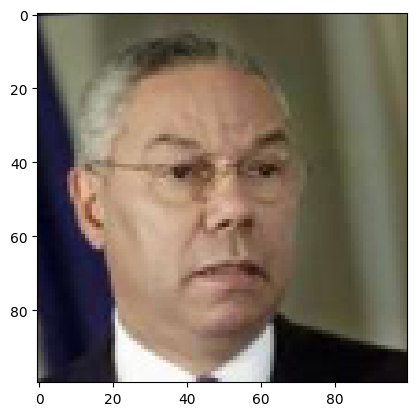

In [3]:
plt.imshow(x_train[0,:,:,:])
plt.show()

In [ ]:
x_train = torch.from_numpy(x_train).permute(0, 3, 1, 2).float() 
x_test = torch.from_numpy(x_test).permute(0, 3, 1, 2).float() 

y_train = torch.from_numpy(y_train).long() 
y_test = torch.from_numpy(y_test).long()

In [5]:
class GenderDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        image = self.x_data[idx]
        label = self.y_data[idx]
        
        image = Image.fromarray(image.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = GenderDataset(x_train, y_train, transform=transform)
test_dataset = GenderDataset(x_test, y_test, transform=transform)

batch_size = 100
num_workers = multiprocessing.cpu_count()-1
print("Num workers", num_workers)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=num_workers)

Num workers 3


In [ ]:
for images, labels in train_loader:
    print(f"Shape of images from DataLoader: {images.shape}") 
    print(f"Shape of labels from DataLoader: {labels.shape}") 
    break

Shape of images from DataLoader: torch.Size([100, 3, 64, 64])
Shape of labels from DataLoader: torch.Size([100])


### **Define Model**

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)

        return x

class GenderCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(GenderCNN, self).__init__()
        
        self.model = nn.Sequential(
            ConvBlock(3, 16),  
            ConvBlock(16, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128)
        )
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 16, num_classes) 

    def forward(self, x):
        x = self.model(x) 
        x = self.flatten(x) 
        x = self.fc(x)
        return x

In [9]:
num_classes = 2
model = GenderCNN(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, min_lr=0.00001)
epochs = 50

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Params: ", count_parameters(model))

Params:  102018


### **Training**

In [10]:
model = model.to(device)
best_test_acc = 0.0
best_model_weights = None 

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
        progress_bar.set_postfix(loss=loss.item())
    
    train_loss /= len(train_loader)
    train_acc = 100. * train_correct / len(train_dataset)
    
    model.eval()
    test_loss, test_correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_acc = 100. * test_correct / len(test_dataset)

    lr_scheduler.step(test_acc)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "model_gender_cnn.pt")
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("\nBest Test Accuracy: ", best_test_acc, " in epoch ", best_epoch)

Epoch 1/50: 100%|██████████| 106/106 [00:04<00:00, 26.06it/s, loss=0.418]


Epoch 1/50, Train Loss: 0.8336, Train Acc: 76.94%, Test Loss: 0.4479, Test Acc: 80.14%


Epoch 2/50: 100%|██████████| 106/106 [00:03<00:00, 35.08it/s, loss=0.445]


Epoch 2/50, Train Loss: 0.3788, Train Acc: 83.38%, Test Loss: 0.4087, Test Acc: 83.61%


Epoch 3/50: 100%|██████████| 106/106 [00:03<00:00, 34.76it/s, loss=0.165]


Epoch 3/50, Train Loss: 0.2690, Train Acc: 88.76%, Test Loss: 0.2349, Test Acc: 90.37%


Epoch 4/50: 100%|██████████| 106/106 [00:02<00:00, 36.36it/s, loss=0.129]


Epoch 4/50, Train Loss: 0.1957, Train Acc: 92.24%, Test Loss: 0.1703, Test Acc: 93.24%


Epoch 5/50: 100%|██████████| 106/106 [00:02<00:00, 35.55it/s, loss=0.0964]


Epoch 5/50, Train Loss: 0.1602, Train Acc: 93.70%, Test Loss: 0.2035, Test Acc: 92.67%


Epoch 6/50: 100%|██████████| 106/106 [00:02<00:00, 35.74it/s, loss=0.107] 


Epoch 6/50, Train Loss: 0.1240, Train Acc: 95.12%, Test Loss: 0.1861, Test Acc: 93.01%


Epoch 7/50: 100%|██████████| 106/106 [00:03<00:00, 34.45it/s, loss=0.0899]


Epoch 7/50, Train Loss: 0.1005, Train Acc: 96.15%, Test Loss: 0.1589, Test Acc: 94.60%


Epoch 8/50: 100%|██████████| 106/106 [00:02<00:00, 35.47it/s, loss=0.0322]


Epoch 8/50, Train Loss: 0.0567, Train Acc: 98.10%, Test Loss: 0.1174, Test Acc: 95.92%


Epoch 9/50: 100%|██████████| 106/106 [00:03<00:00, 35.15it/s, loss=0.0263]


Epoch 9/50, Train Loss: 0.0364, Train Acc: 99.07%, Test Loss: 0.1143, Test Acc: 96.34%


Epoch 10/50: 100%|██████████| 106/106 [00:03<00:00, 35.05it/s, loss=0.0089]


Epoch 10/50, Train Loss: 0.0283, Train Acc: 99.28%, Test Loss: 0.1146, Test Acc: 96.26%


Epoch 11/50: 100%|██████████| 106/106 [00:03<00:00, 31.90it/s, loss=0.0266]


Epoch 11/50, Train Loss: 0.0220, Train Acc: 99.54%, Test Loss: 0.1174, Test Acc: 96.41%


Epoch 12/50: 100%|██████████| 106/106 [00:03<00:00, 34.62it/s, loss=0.00448]


Epoch 12/50, Train Loss: 0.0170, Train Acc: 99.77%, Test Loss: 0.1176, Test Acc: 96.49%


Epoch 13/50: 100%|██████████| 106/106 [00:02<00:00, 35.79it/s, loss=0.00753]


Epoch 13/50, Train Loss: 0.0131, Train Acc: 99.87%, Test Loss: 0.1185, Test Acc: 96.37%


Epoch 14/50: 100%|██████████| 106/106 [00:02<00:00, 36.03it/s, loss=0.00815]


Epoch 14/50, Train Loss: 0.0096, Train Acc: 99.98%, Test Loss: 0.1191, Test Acc: 96.45%


Epoch 15/50: 100%|██████████| 106/106 [00:03<00:00, 35.12it/s, loss=0.00722]


Epoch 15/50, Train Loss: 0.0090, Train Acc: 99.98%, Test Loss: 0.1201, Test Acc: 96.41%


Epoch 16/50: 100%|██████████| 106/106 [00:02<00:00, 35.64it/s, loss=0.0119] 


Epoch 16/50, Train Loss: 0.0087, Train Acc: 99.98%, Test Loss: 0.1205, Test Acc: 96.37%


Epoch 17/50: 100%|██████████| 106/106 [00:02<00:00, 36.01it/s, loss=0.00623]


Epoch 17/50, Train Loss: 0.0084, Train Acc: 99.98%, Test Loss: 0.1208, Test Acc: 96.41%


Epoch 18/50: 100%|██████████| 106/106 [00:02<00:00, 37.00it/s, loss=0.0101] 


Epoch 18/50, Train Loss: 0.0081, Train Acc: 99.99%, Test Loss: 0.1214, Test Acc: 96.37%


Epoch 19/50: 100%|██████████| 106/106 [00:03<00:00, 32.10it/s, loss=0.00627]


Epoch 19/50, Train Loss: 0.0080, Train Acc: 99.98%, Test Loss: 0.1212, Test Acc: 96.45%


Epoch 20/50: 100%|██████████| 106/106 [00:02<00:00, 35.99it/s, loss=0.00735]


Epoch 20/50, Train Loss: 0.0076, Train Acc: 99.99%, Test Loss: 0.1217, Test Acc: 96.45%


Epoch 21/50: 100%|██████████| 106/106 [00:02<00:00, 35.90it/s, loss=0.00898]


Epoch 21/50, Train Loss: 0.0076, Train Acc: 99.99%, Test Loss: 0.1215, Test Acc: 96.45%


Epoch 22/50: 100%|██████████| 106/106 [00:02<00:00, 36.37it/s, loss=0.00484]


Epoch 22/50, Train Loss: 0.0077, Train Acc: 99.98%, Test Loss: 0.1218, Test Acc: 96.45%


Epoch 23/50: 100%|██████████| 106/106 [00:03<00:00, 34.86it/s, loss=0.00684]


Epoch 23/50, Train Loss: 0.0075, Train Acc: 99.99%, Test Loss: 0.1218, Test Acc: 96.41%


Epoch 24/50: 100%|██████████| 106/106 [00:02<00:00, 36.23it/s, loss=0.00555]


Epoch 24/50, Train Loss: 0.0076, Train Acc: 99.99%, Test Loss: 0.1220, Test Acc: 96.45%


Epoch 25/50: 100%|██████████| 106/106 [00:03<00:00, 34.78it/s, loss=0.00867]


Epoch 25/50, Train Loss: 0.0075, Train Acc: 99.98%, Test Loss: 0.1217, Test Acc: 96.45%


Epoch 26/50: 100%|██████████| 106/106 [00:02<00:00, 36.25it/s, loss=0.00548]


Epoch 26/50, Train Loss: 0.0076, Train Acc: 99.97%, Test Loss: 0.1225, Test Acc: 96.45%


Epoch 27/50: 100%|██████████| 106/106 [00:03<00:00, 33.25it/s, loss=0.0157] 


Epoch 27/50, Train Loss: 0.0075, Train Acc: 99.99%, Test Loss: 0.1218, Test Acc: 96.45%


Epoch 28/50: 100%|██████████| 106/106 [00:03<00:00, 35.32it/s, loss=0.0026] 


Epoch 28/50, Train Loss: 0.0073, Train Acc: 99.98%, Test Loss: 0.1215, Test Acc: 96.37%


Epoch 29/50: 100%|██████████| 106/106 [00:02<00:00, 35.64it/s, loss=0.00887]


Epoch 29/50, Train Loss: 0.0074, Train Acc: 99.98%, Test Loss: 0.1220, Test Acc: 96.45%


Epoch 30/50: 100%|██████████| 106/106 [00:02<00:00, 36.68it/s, loss=0.0119] 


Epoch 30/50, Train Loss: 0.0075, Train Acc: 99.99%, Test Loss: 0.1219, Test Acc: 96.45%


Epoch 31/50: 100%|██████████| 106/106 [00:02<00:00, 35.59it/s, loss=0.00562]


Epoch 31/50, Train Loss: 0.0073, Train Acc: 99.99%, Test Loss: 0.1223, Test Acc: 96.45%


Epoch 32/50: 100%|██████████| 106/106 [00:02<00:00, 35.80it/s, loss=0.00488]


Epoch 32/50, Train Loss: 0.0072, Train Acc: 99.99%, Test Loss: 0.1221, Test Acc: 96.37%


Epoch 33/50: 100%|██████████| 106/106 [00:03<00:00, 34.91it/s, loss=0.00381]


Epoch 33/50, Train Loss: 0.0072, Train Acc: 99.99%, Test Loss: 0.1221, Test Acc: 96.41%


Epoch 34/50: 100%|██████████| 106/106 [00:02<00:00, 35.97it/s, loss=0.00473]


Epoch 34/50, Train Loss: 0.0071, Train Acc: 99.99%, Test Loss: 0.1227, Test Acc: 96.45%


Epoch 35/50: 100%|██████████| 106/106 [00:02<00:00, 36.14it/s, loss=0.00464]


Epoch 35/50, Train Loss: 0.0071, Train Acc: 99.99%, Test Loss: 0.1226, Test Acc: 96.45%


Epoch 36/50: 100%|██████████| 106/106 [00:03<00:00, 32.88it/s, loss=0.00755]


Epoch 36/50, Train Loss: 0.0070, Train Acc: 99.98%, Test Loss: 0.1223, Test Acc: 96.45%


Epoch 37/50: 100%|██████████| 106/106 [00:02<00:00, 36.45it/s, loss=0.00386]


Epoch 37/50, Train Loss: 0.0071, Train Acc: 99.99%, Test Loss: 0.1227, Test Acc: 96.53%


Epoch 38/50: 100%|██████████| 106/106 [00:02<00:00, 35.40it/s, loss=0.00496]


Epoch 38/50, Train Loss: 0.0070, Train Acc: 99.99%, Test Loss: 0.1219, Test Acc: 96.45%


Epoch 39/50: 100%|██████████| 106/106 [00:02<00:00, 35.86it/s, loss=0.0108] 


Epoch 39/50, Train Loss: 0.0068, Train Acc: 99.99%, Test Loss: 0.1233, Test Acc: 96.56%


Epoch 40/50: 100%|██████████| 106/106 [00:02<00:00, 35.76it/s, loss=0.00393]


Epoch 40/50, Train Loss: 0.0068, Train Acc: 99.99%, Test Loss: 0.1239, Test Acc: 96.49%


Epoch 41/50: 100%|██████████| 106/106 [00:03<00:00, 35.03it/s, loss=0.0128] 


Epoch 41/50, Train Loss: 0.0069, Train Acc: 99.99%, Test Loss: 0.1234, Test Acc: 96.49%


Epoch 42/50: 100%|██████████| 106/106 [00:02<00:00, 35.49it/s, loss=0.00427]


Epoch 42/50, Train Loss: 0.0067, Train Acc: 99.99%, Test Loss: 0.1234, Test Acc: 96.53%


Epoch 43/50: 100%|██████████| 106/106 [00:02<00:00, 35.39it/s, loss=0.0139] 


Epoch 43/50, Train Loss: 0.0066, Train Acc: 99.99%, Test Loss: 0.1234, Test Acc: 96.49%


Epoch 44/50: 100%|██████████| 106/106 [00:03<00:00, 32.30it/s, loss=0.00933]


Epoch 44/50, Train Loss: 0.0068, Train Acc: 99.99%, Test Loss: 0.1232, Test Acc: 96.45%


Epoch 45/50: 100%|██████████| 106/106 [00:02<00:00, 36.53it/s, loss=0.00441]


Epoch 45/50, Train Loss: 0.0067, Train Acc: 99.99%, Test Loss: 0.1231, Test Acc: 96.56%


Epoch 46/50: 100%|██████████| 106/106 [00:03<00:00, 35.11it/s, loss=0.0177] 


Epoch 46/50, Train Loss: 0.0065, Train Acc: 99.99%, Test Loss: 0.1233, Test Acc: 96.41%


Epoch 47/50: 100%|██████████| 106/106 [00:02<00:00, 35.80it/s, loss=0.00493]


Epoch 47/50, Train Loss: 0.0065, Train Acc: 99.99%, Test Loss: 0.1240, Test Acc: 96.45%


Epoch 48/50: 100%|██████████| 106/106 [00:02<00:00, 36.06it/s, loss=0.0075] 


Epoch 48/50, Train Loss: 0.0065, Train Acc: 99.99%, Test Loss: 0.1235, Test Acc: 96.49%


Epoch 49/50: 100%|██████████| 106/106 [00:02<00:00, 37.32it/s, loss=0.00542]


Epoch 49/50, Train Loss: 0.0065, Train Acc: 99.99%, Test Loss: 0.1242, Test Acc: 96.53%


Epoch 50/50: 100%|██████████| 106/106 [00:02<00:00, 35.36it/s, loss=0.00566]


Epoch 50/50, Train Loss: 0.0063, Train Acc: 99.99%, Test Loss: 0.1245, Test Acc: 96.56%

Best Test Accuracy:  96.56344410876133  in epoch  39


### **Evaluación**

In [11]:
model.load_state_dict(best_model_weights)
model.eval() 

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [12]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix  

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')  
cm = confusion_matrix(all_labels, all_preds)

print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1-score: {f1:.4f}")

Final Accuracy: 0.9656
Final F1-score: 0.9504


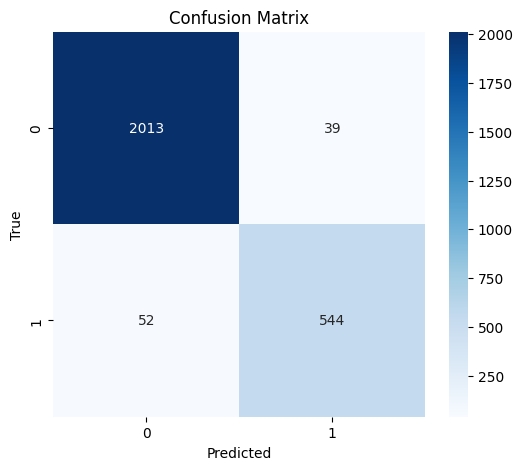

In [13]:
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()